<a href="https://colab.research.google.com/github/glyngdoh/machine_learning_examples/blob/master/EQ_Challenge_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# to acess the kaggle datasets
! pip install kaggle
# Math operations
!pip install numpy
# machine learning
!pip install catboost

     |████████████████████████████████| 66.1MB 71kB/s 


In [2]:
# data processing
import pandas as pd
# math operations
import numpy as np
# machine learning
from catboost import CatBoostRegressor, Pool
# data scaling 
from sklearn.preprocessing import StandardScaler
# hyper-parameter optimization
from sklearn.model_selection import GridSearchCV
# support vector machine model
from sklearn.svm import  NuSVR, SVR
# kernel ridge model
from sklearn.kernel_ridge import KernelRidge
# data visualization 
import matplotlib.pyplot as plt


In [3]:
# colab's file access feature
from google.colab import  files

#retrieve uploaded file
uploaded = files.upload()

# then move kaggle.json into the folder where the API expects to find
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-cp36-none-any.whl size=73275 sha256=aa36847924c4bdcf3fd82a13fbda0512675be3e22f589321ad2cbd8db1f50702
  Stored in directory: /root/.cache/pip/wheels/94/a7/09/68dc83c7c14fdbdf5d3f2b2da5b87e587bfc1e85df69b1130c
Successfully built kaggle
  Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8


In [6]:
# download the earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

LANL-Earthquake-Prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# unzip training data for usage, will take about 5 minutes (it's big)
!unzip LANL-Earthquake-Prediction.zip

Archive:  LANL-Earthquake-Prediction.zip
  inflating: sample_submission.csv   
  inflating: test/seg_00030f.csv     
  inflating: test/seg_0012b5.csv     
  inflating: test/seg_00184e.csv     
  inflating: test/seg_003339.csv     
  inflating: test/seg_0042cc.csv     
  inflating: test/seg_004314.csv     
  inflating: test/seg_004cd2.csv     
  inflating: test/seg_004ee5.csv     
  inflating: test/seg_004f1f.csv     
  inflating: test/seg_00648a.csv     
  inflating: test/seg_006e4a.csv     
  inflating: test/seg_007a37.csv     
  inflating: test/seg_00a37e.csv     
  inflating: test/seg_00be11.csv     
  inflating: test/seg_00c35b.csv     
  inflating: test/seg_00cc91.csv     
  inflating: test/seg_00e5f7.csv     
  inflating: test/seg_00f3b9.csv     
  inflating: test/seg_010eab.csv     
  inflating: test/seg_0125d9.csv     
  inflating: test/seg_0144cb.csv     
  inflating: test/seg_0165c6.csv     
  inflating: test/seg_016913.csv     
  inflating: test/seg_016cdb.csv     
  inflati

In [8]:
# extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [9]:
# print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


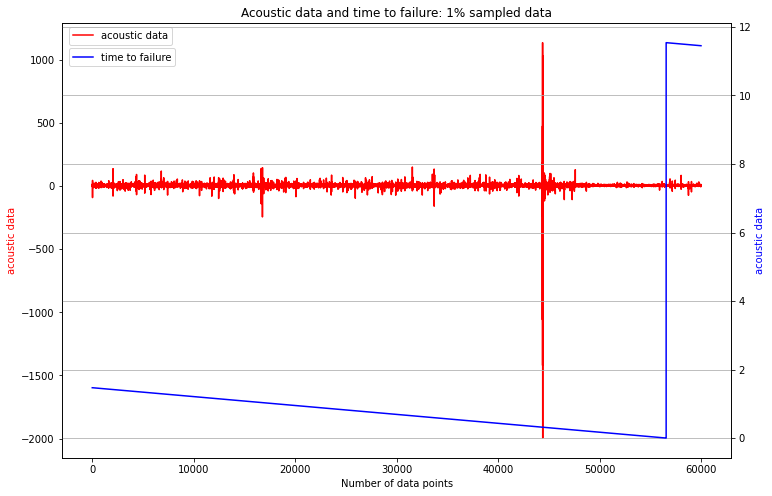

In [10]:
# visualize1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]
# function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title):
  fig, ax1 = plt.subplots(figsize=(12,8))
  plt.title(title)
  plt.plot(train_ad_sample_df,color='r')
  ax1.set_ylabel('acoustic data', color='r')
  ax1.set_xlabel('Number of data points')
  plt.legend(['acoustic data'], loc=(0.01, 0.95))
  ax2 = ax1.twinx()
  plt.plot(train_ttf_sample_df,color='b')
  ax2.set_ylabel('acoustic data', color='b')
  plt.legend(['time to failure'], loc=(0.01, 0.9))
  plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df,train_ttf_sample_df,'Acoustic data and time to failure: 1% sampled data')
del train_ad_sample_df, train_ttf_sample_df
  


In [45]:
# step-4: Feature engineering and significance of these statisitical 
# let's create a function to generate some statistical features based on the past models
def gen_features(X):
  strain = []
  strain.append(X.mean())
  strain.append(X.std())
  strain.append(X.min())
  strain.append(X.kurtosis())
  strain.append(X.skew())
  strain.append(X.quantile(0.01))
  return strain
# def gen_features(X):
#   print(X.mean())
#   print(X.std())
#   print(X.min())
#   print(X.kurtosis())
#   print(X.skew())
#   print(X.quantile(0.01))
#   return None

In [19]:
train = pd.read_csv('train.csv',iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

In [46]:
X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
  X = df['acoustic_data']
  ch = gen_features(X)
  ch = pd.Series(ch)
  X_train = X_train.append(ch, ignore_index=True)
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


In [47]:
X_train.describe()

,0,1,2,3,4,5
count,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000,3984.000000
mean,4.521908,6.577607,-149.864207,68.535401,0.126501,-11.311293
std,0.258148,8.461537,262.013861,71.117943,0.478568,14.160347
min,3.596313,2.802720,-5515.000000,0.648602,-4.091826,-336.000000
25%,4.349597,4.492854,-155.250000,28.099582,-0.040050,-14.000000
50%,4.526650,5.646141,-111.000000,45.887267,0.086270,-10.000000
75%,4.696270,6.911484,-80.000000,78.521555,0.254871,-6.000000
max,5.391993,153.703569,-15.000000,631.158927,4.219429,-2.000000


In [48]:
# model #1 - Catboost
train_pool = Pool(X_train, y_train)
model = CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
model.fit(X_train,y_train, silent=True)
model.best_score_


AttributeError: ignored

In [49]:
model.best_score_

{'learn': {'MAE': 1.432345236764648}}

In [52]:
# model #2 - SVM with RBF kernel
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]
model2_initial = SVR(kernel='rbf', tol=0.01)
model2 = GridSearchCV(model2_initial, parameters, cv=5)
model2.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = model2.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(model2.best_score_))
print(model2.best_params_)

Best CV score: 0.3634
{'C': 2, 'gamma': 0.1}
